# IEEE-CIS Fraud Detection
                  


<div>
<img src="attachment:creditcard.jpg" width="500" align = "left" />
</div>

Source - https://www.kaggle.com/competitions/ieee-fraud-detection

In this kaggle competetion we need to need to predict the probabilty of transaction being fraud.

Business constraints :

1) Cost of misclassification can be high - If any legit transaction is detected to be fraud then raising the false alaram will  lead to bad customer experience.

2) Low latency requirements - If there is any kind of fraud transaction, it should immediately get caught so that the card can be blocked by company.

3) Interpretability - Should know the proability of transaction being fraud and non-fraud.

4) Performance - The model should be robust to predict the transaction and legit or fraudulent with higher accuracy.


# 1. Load Data

In [1]:
import copy
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
#set display option for rows & columns
pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

Lets, first load the train and test dataset which is broken into two different dataset transaction and identity

In [ ]:
# loading train transaction data
train_transaction = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_transaction.csv')
print(train_transaction.shape)

train_transaction = reduce_mem_usage(train_transaction)
train_transaction.head(20)

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 542.35 MB
Decreased by 69.4%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.

In [ ]:
# Loading train identity data
train_identity = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_identity.csv')
print(train_identity.shape)

train_identity = reduce_mem_usage(train_identity)
train_identity.head(4)

(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 25.86 MB
Decreased by 42.7%


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN


# EDA

In [ ]:
# isFraud is the target attribute
col = 'isFraud'
trx = train_transaction['isFraud'].value_counts().reset_index().rename({'index':'Value','isFraud':'Count'}, axis=1)
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 6)
print('Value counts Table:')
print(trx)
print('-'*50)
trx = train_transaction.copy()
corrs = trx[[f for f in train_transaction.columns if train_transaction[f].dtype != 'object']].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
trx = pd.concat([corrs[1:6], corrs.dropna().tail(5)])
print('Correlation Table:')
print(trx)

Value counts Table:
   Value   Count    Share
0      0  569877  0.96501
1      1   20663  0.03499
--------------------------------------------------
Correlation Table:
    Column  Correlation with isFraud
1     V257                  0.383060
2     V246                  0.366878
3     V244                  0.364129
4     V242                  0.360590
5     V201                  0.328005
375    V90                 -0.110168
376    V49                 -0.110920
377    V48                 -0.115786
378     D7                 -0.127199
379     D8                 -0.142634


In [ ]:
# EDA of TransactionID, isFraud & TransactionDT
col = 'TransactionDT'
trx = train_transaction.copy()
corrs = train_transaction[[f for f in train_transaction.columns if train_transaction[f].dtype != 'object']].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
trx = pd.concat([corrs[1:6], corrs.dropna().tail(5)])
print('Correlation Table:')
print(trx)

Correlation Table:
            Column  Correlation with TransactionDT
1    TransactionID                        0.998280
2             V330                        0.258603
3             V326                        0.257295
4             V329                        0.252599
5             V327                        0.248494
375           V145                       -0.252731
376           V160                       -0.265566
377           V159                       -0.279137
378           V151                       -0.280576
379           V150                       -0.284073


**Observation**:
'TransactionID' and 'TransactionDT' are very strongly correlated. This implies that each TransactionID is generated at a unique Transaction time.
Value counts of 'isFraud' column shows that the dataset is highly unbalanced. There are 96.5% negative datapoints and 3.5% positive datapoints on 'isFraud' label.

In [ ]:
col_rem_eda = ['TransactionID', 'isFraud', 'TransactionDT']

In [ ]:
tr=train_transaction
del train_transaction

In [ ]:
import gc

def EDA_num(col):
    '''
    frequency distribution +
    Box plot +
    Attribute description (mean, std) +
    top 5 positive and top 5 negative correlations
    '''
    trx = tr.copy()
    
    print('='*50)
    print('Attribute: ',col)
    i = col
    tr[col].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title=f'Train {col} distribution')
    plt.show()    
    isFraud = trx[trx['isFraud']==1][i].values
    notFraud = trx[trx['isFraud']==0][i].values

    # https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
    plt.boxplot([isFraud,notFraud])
    plt.title('Box Plot:')
    plt.xticks([1,2],('isFraud','notFraud'))
    plt.ylabel(i)
    plt.grid()
    plt.show()

    if np.isnan(trx[i]).any():
        print('percentage of missing values:', 100*(np.isnan(trx[i]).sum())/len(trx))
    else:
        print('There are no missing values in this feature')

    temp = pd.DataFrame(index = (trx[col].describe()).index)
    temp['Train'] = trx[col].describe()
    temp['isFraud Train'] = trx[trx['isFraud']==1][col].describe()
    temp['isNotFraud Train'] = trx[trx['isFraud']==0][col].describe()
    print('-'*50)
    print('Correlations: ')
    corrs = trx[[f for f in tr.columns if tr[f].dtype != 'object']].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    trx = pd.concat([corrs[1:6], corrs.dropna().tail(5)])
    print(trx)
    gc.collect()
    print('-'*50)  
    print('Describing ', col,' :')
    print(temp)

def EDA_cat(col):
    '''
    Value counts of categoical attributes + % of missing values
    '''
    print('-'*50)
    print('Attribute: ',col)
    i = col
    trx = tr.copy()
    if pd.isnull(trx[i]).any():
        print('percentage of missing values:', 100*(pd.isnull(trx[i]).sum())/len(trx))
    else:
        print('There are no missing values in this feature')
    
    temp = pd.DataFrame(index = (trx[col].value_counts()).index)
    temp['Train'] = trx[col].value_counts()
    temp['isFraud Train'] = trx[trx['isFraud']==1][col].value_counts()
    temp['isNotFraud Train'] = trx[trx['isFraud']==0][col].value_counts()
    print(pd.DataFrame(temp).head(10))
    print('-'*50)

Attribute:  TransactionAmt


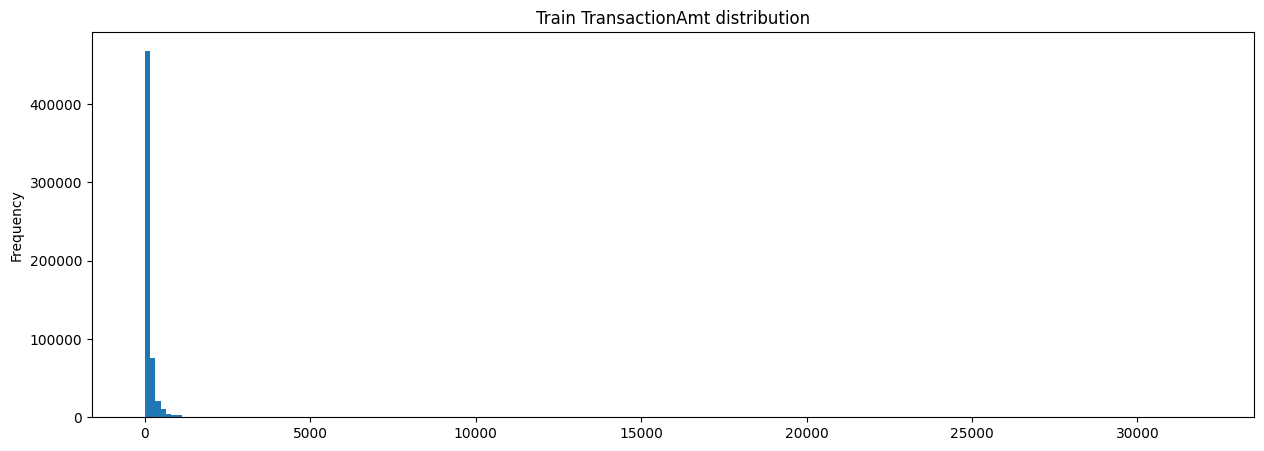

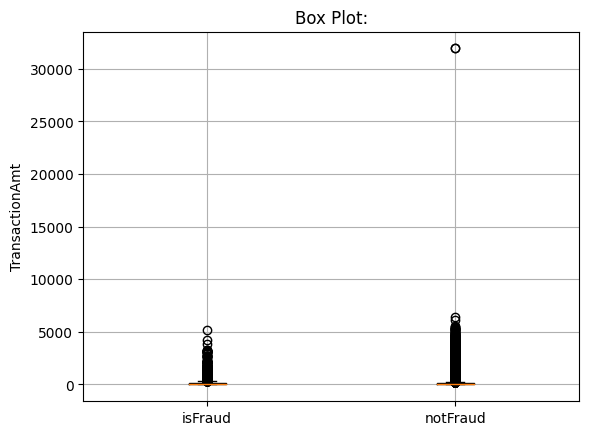

There are no missing values in this feature
--------------------------------------------------
Correlations: 
    Column  Correlation with TransactionAmt
1     V139                         0.222308
2     V140                         0.207470
3     V208                         0.198601
4     V161                         0.197352
5     V163                         0.191320
375    V15                        -0.139417
376    V94                        -0.141019
377    V52                        -0.142302
378    V50                        -0.144963
379    V51                        -0.149464
--------------------------------------------------
Describing  TransactionAmt  :
               Train  isFraud Train  isNotFraud Train
count  590540.000000   2.066300e+04     569877.000000
mean             NaN            inf               NaN
std              NaN            inf               NaN
min         0.250977   2.919922e-01          0.250977
25%        43.312500   3.503125e+01         43.968750
5

In [ ]:
# EDA sample on Numerical data
EDA_num('TransactionAmt')

In [ ]:
# EDA sample on categorical data
EDA_cat('ProductCD')

--------------------------------------------------
Attribute:  ProductCD
There are no missing values in this feature
    Train  isFraud Train  isNotFraud Train
W  439670           8969            430701
C   68519           8008             60511
R   37699           1426             36273
H   33024           1574             31450
S   11628            686             10942
--------------------------------------------------


**Data visualization and analysis**

In [ ]:
for f in tr.columns:
    if f not in col_rem_eda:
        if tr[f].dtype != 'object':
            EDA_num(f)
        elif tr[f].dtype == 'object':
            EDA_cat(f)

Output hidden; open in https://colab.research.google.com to view.

In [5]:
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
cols_v = ['V'+str(x) for x in range(1,340)]; types_v = {}
for c in cols_v: types_v[c] = 'float32'
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_transaction.csv',usecols=cols_t+['isFraud']+cols_v,dtype=types_v)

In [6]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 1011.48 MB
Memory usage after optimization is: 542.35 MB
Decreased by 46.4%


**NAN Search**

In [7]:
import gc
nans_df = train.isna()
nans_groups={}
i_cols = ['V'+str(i) for i in range(1,340)]
for col in cols_v:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 279287
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
####### NAN count = 76073
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
####### NAN count = 168969
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']
####### NAN count = 77096
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
####### NAN count = 89164
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']
####### NAN count = 314
['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V

In [8]:
groups_with_subgroups = []

for missing_count, grp in nans_groups.items():

  children = set()
  parent_dict = {parent:copy.deepcopy(children) for parent in grp}
  corr = train[grp].corr()
  
  for row in corr.iterrows():
    parent = row[0]
    for child,parent_child_corr in row[1].items():  
      if(parent is not child and parent_child_corr>=0.75):
        parent_dict[parent].add(child)
    
  groups_with_subgroups.append(parent_dict)

**We can observe correlations between (V2 and V3), (V4 and V5), (V6 and V7), (V8 and V9) and (V10 and V11)**

In [9]:
visited = {"V"+str(i):False for i in range(1,340) if "V"+str(i) in train.columns}
final_grps = []

for grps in groups_with_subgroups:
  
  grp={}

  for parent,children in grps.items():
  
    if(not visited[parent]):
      
      s = set()
      grp[parent] = copy.deepcopy(s)
      for child in children:
      
        if(not visited[child]):
      
          grp[parent].add(child)
          visited[child]=True
      
      visited[parent]=True
  
  final_grps.append(grp)

In [10]:
final_grps

[{'V1': set(),
  'V2': {'V3'},
  'V4': {'V5'},
  'V6': {'V7'},
  'V8': {'V9'},
  'V10': {'V11'}},
 {'V12': {'V13'},
  'V14': set(),
  'V15': {'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'},
  'V19': {'V20'},
  'V23': {'V24'},
  'V25': {'V26'},
  'V27': {'V28'},
  'V29': {'V30'}},
 {'V35': {'V36'},
  'V37': {'V38'},
  'V39': {'V40', 'V42', 'V43', 'V50', 'V51'},
  'V41': set(),
  'V44': {'V45'},
  'V46': {'V47'},
  'V48': {'V49'},
  'V52': set()},
 {'V53': {'V54'},
  'V55': set(),
  'V56': set(),
  'V57': {'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'},
  'V61': {'V62'},
  'V65': set(),
  'V66': {'V67'},
  'V68': set(),
  'V69': {'V70'}},
 {'V75': {'V76'},
  'V77': {'V78'},
  'V79': {'V81', 'V84', 'V85', 'V92', 'V93', 'V94'},
  'V80': set(),
  'V82': {'V83'},
  'V86': {'V87'},
  'V88': set(),
  'V89': set(),
  'V90': {'V91'}},
 {'V95': {'V101',
   'V102',
   'V103',
   'V105',
   'V106',
   'V126',
   'V127',
   'V128',
   'V132',
   'V133',
   'V134',
   

In [11]:
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id

def reduce_group(grps):
    global train
    chosen = []
    for parent, children in grps.items():
      max_unique = train[parent].nunique(); max_unique_child = parent
      for child in children:
        n = train[child].nunique()
        if n>max_unique:
            max_unique = n
            max_unique_child = child
      chosen.append(max_unique_child)

    print('Use these', chosen)

    return chosen

In [12]:
chosen_v_features = []

for grps in final_grps:
  chosen_v_features+=reduce_group(grps)

Use these ['V1', 'V3', 'V4', 'V6', 'V8', 'V11']
Use these ['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']
Use these ['V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V52']
Use these ['V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']
Use these ['V76', 'V78', 'V81', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']
Use these ['V127', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V111', 'V114', 'V115', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V129', 'V130', 'V131', 'V136']
Use these ['V138', 'V139', 'V142', 'V147', 'V156', 'V162']
Use these ['V165', 'V160', 'V166']
Use these ['V203', 'V207', 'V173', 'V176', 'V183', 'V187', 'V205', 'V216', 'V215']
Use these ['V169', 'V171', 'V174', 'V175', 'V180', 'V185', 'V188', 'V195', 'V198', 'V210', 'V209']
Use these ['V274', 'V223', 'V264', 'V263', 'V230', 'V235', 'V240', 'V241', 'V257', 'V252', 'V258', 'V260', 'V262', 'V265', 'V268', 'V277']
Use these ['V220', 'V221', 'V234', 'V238', 'V250', 'V256', 'V271']
Use these ['V307', 

In [13]:
def make_plots2(Vs):
    '''
    plotting histograms
    '''
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        idx = train[~train[v].isna()].index
        n = train[v].nunique()
        x = np.sum(train.loc[idx,v]!=train.loc[idx,v].astype(int))
        y = np.round(100*np.sum(train[v].isna())/len(train),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(train.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()

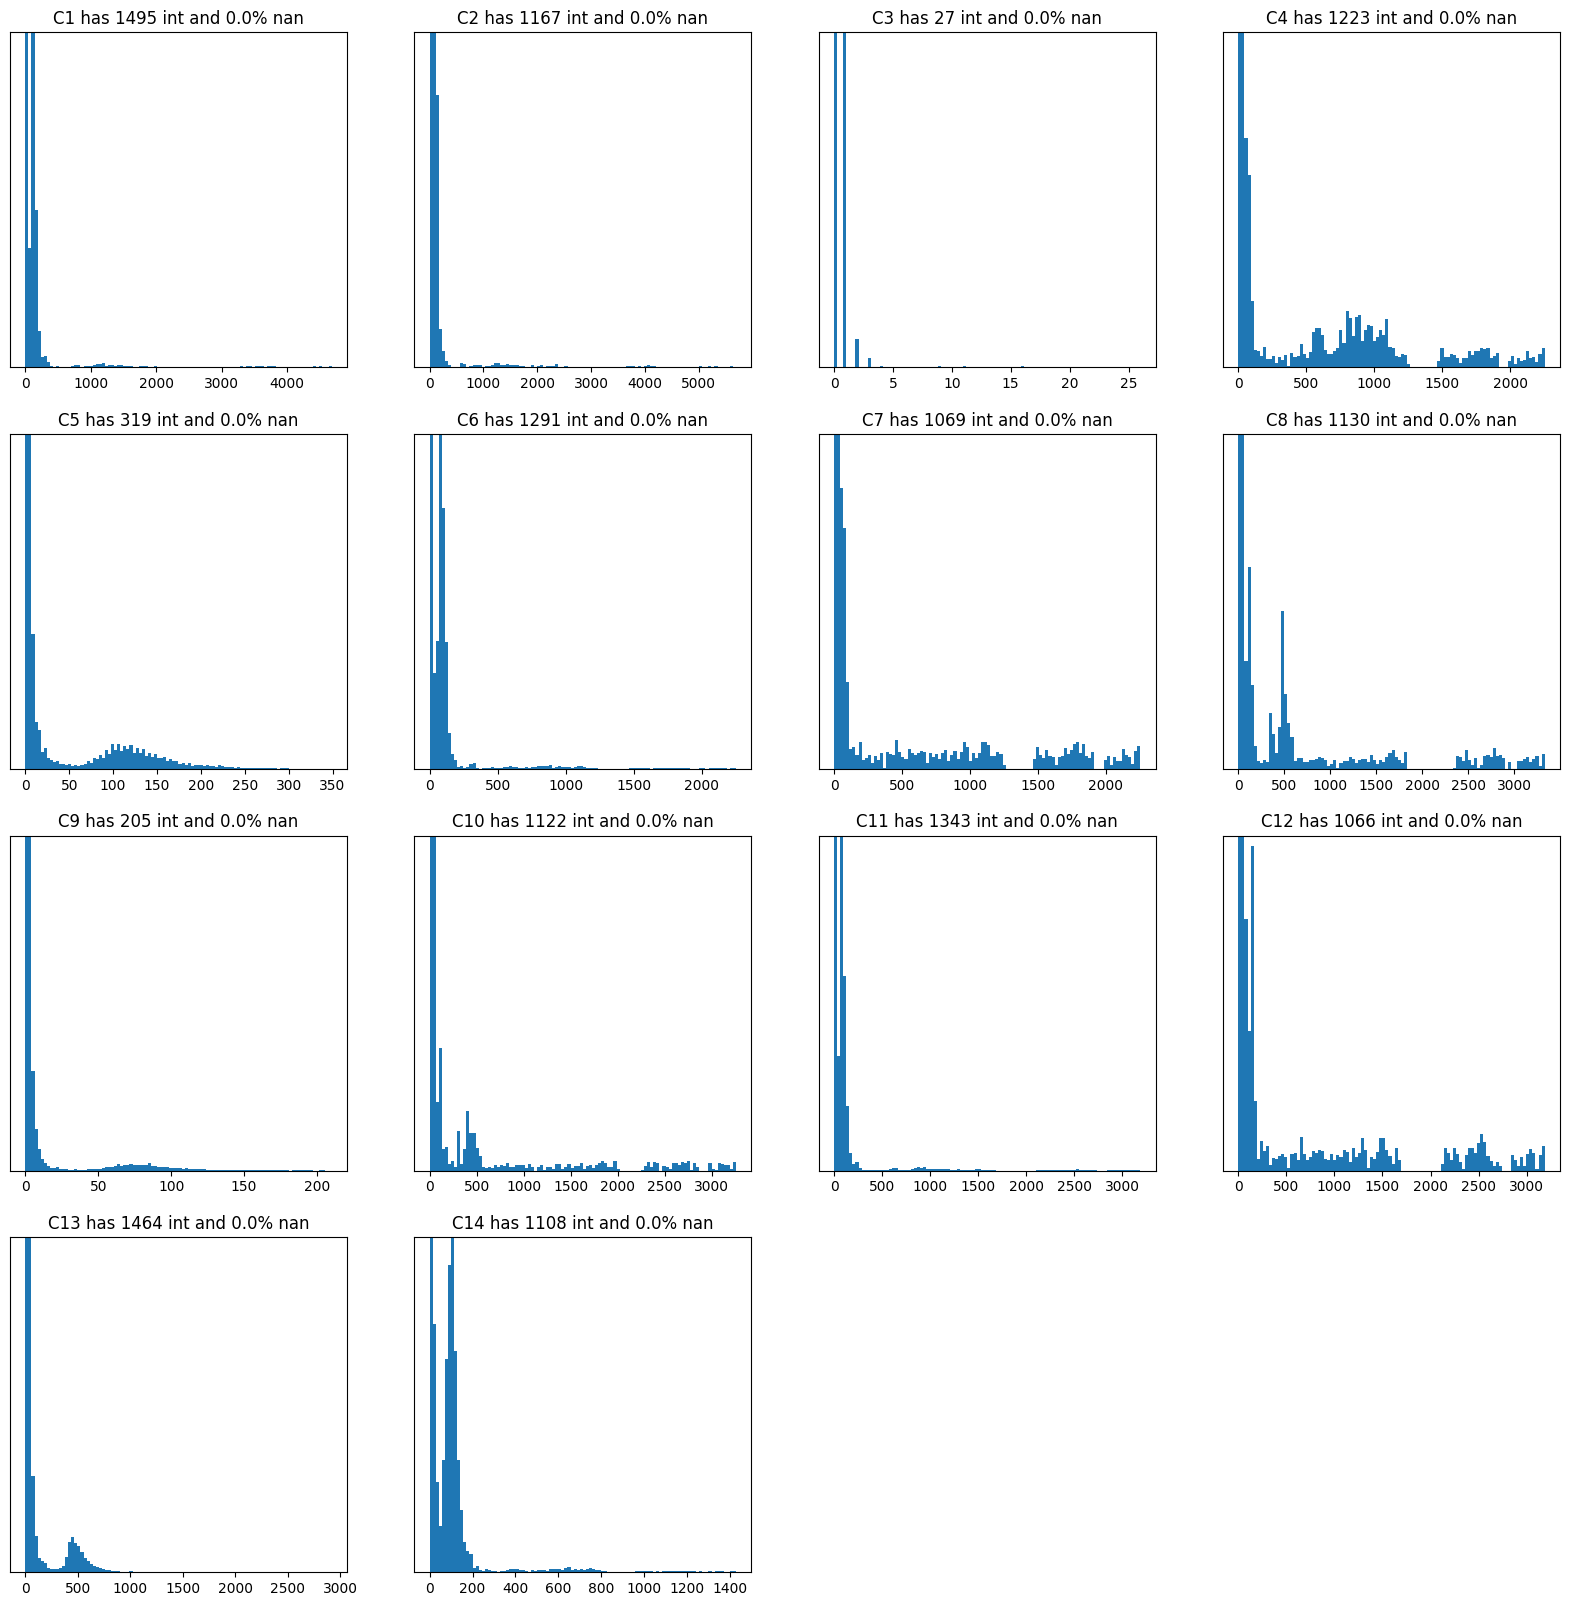

In [14]:
make_plots2(['C'+str(x) for x in range(1,15)])

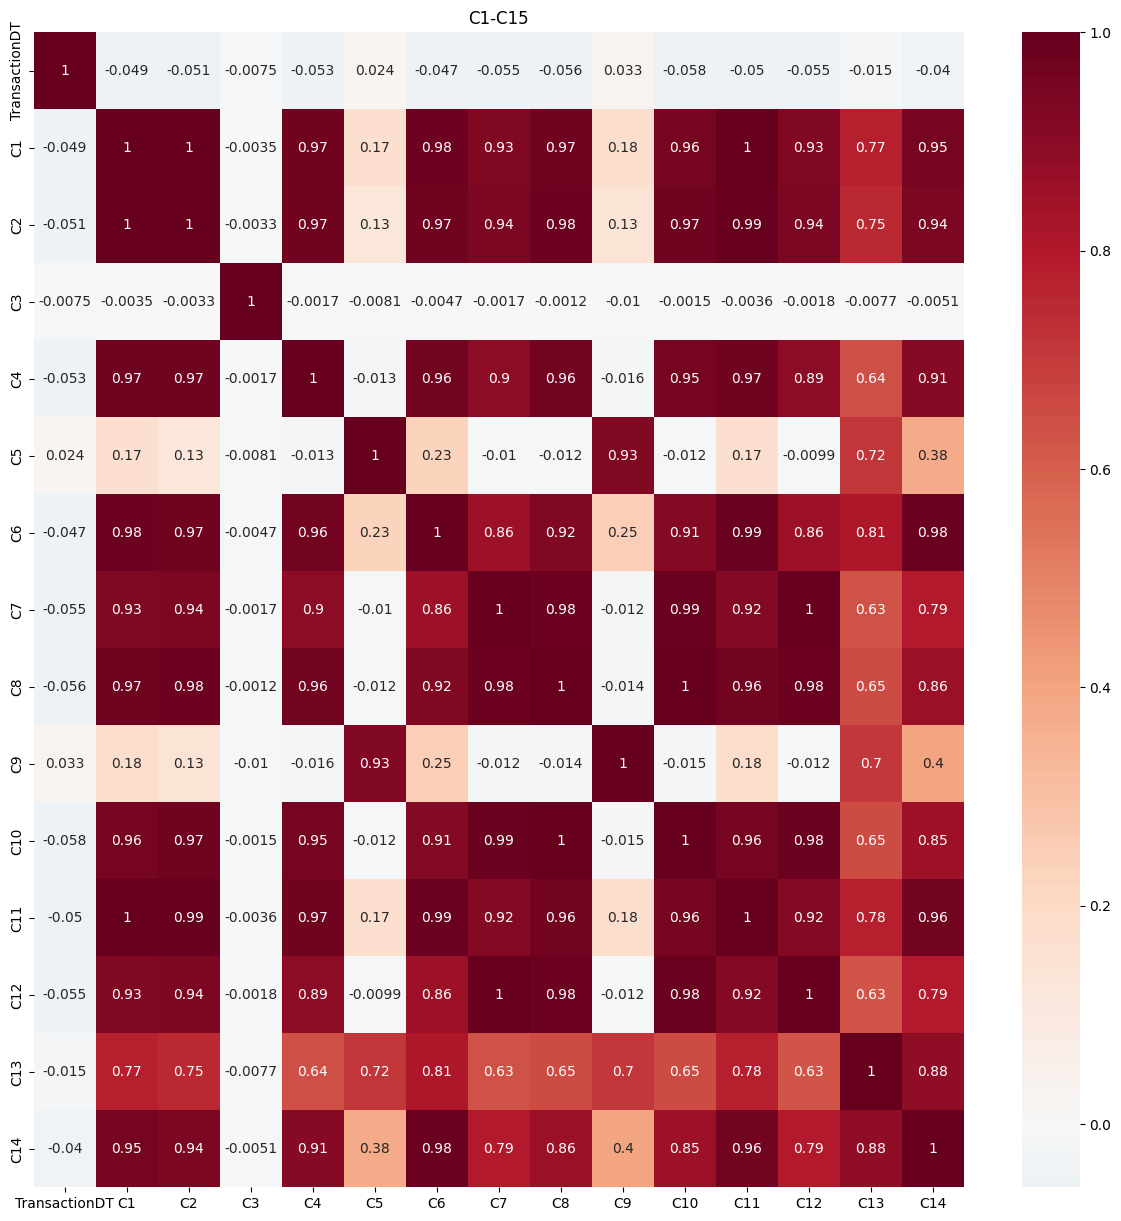

In [15]:
cols = ['TransactionDT'] + ['C'+str(x) for x in range(1,15)]
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('C1-C15')
plt.show()

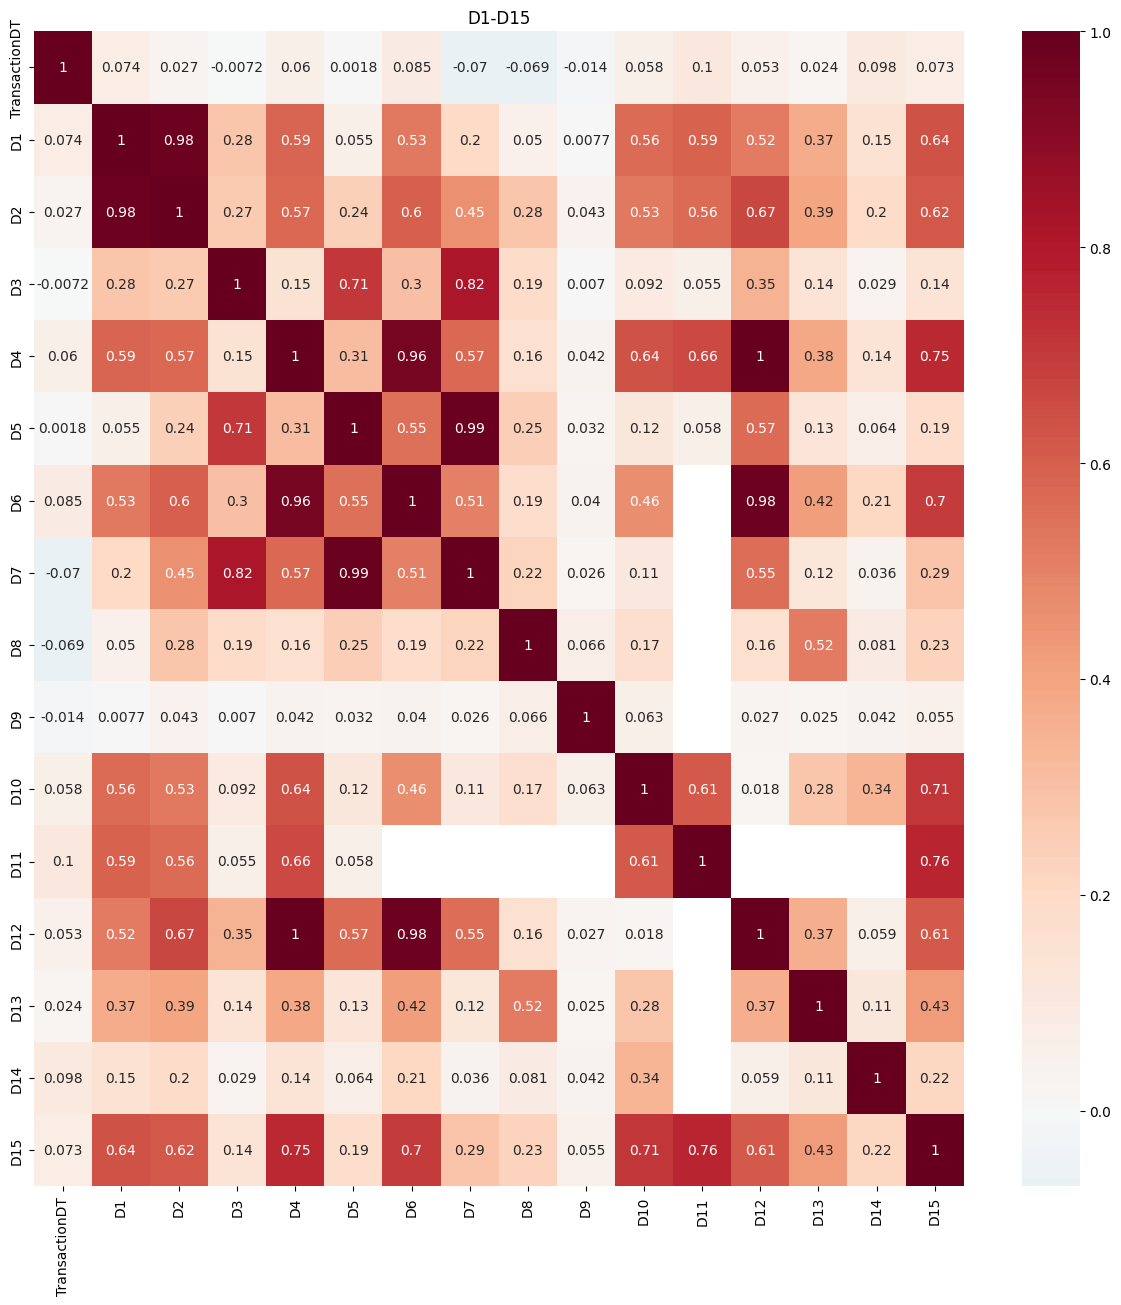

In [16]:
cols = ['TransactionDT'] + ['D'+str(x) for x in range(1,16)]
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('D1-D15')
plt.show()

In [17]:
Ms = ['M'+str(x) for x in range(1,10)]
mp = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in Ms: train[c] = train[c].map(mp)

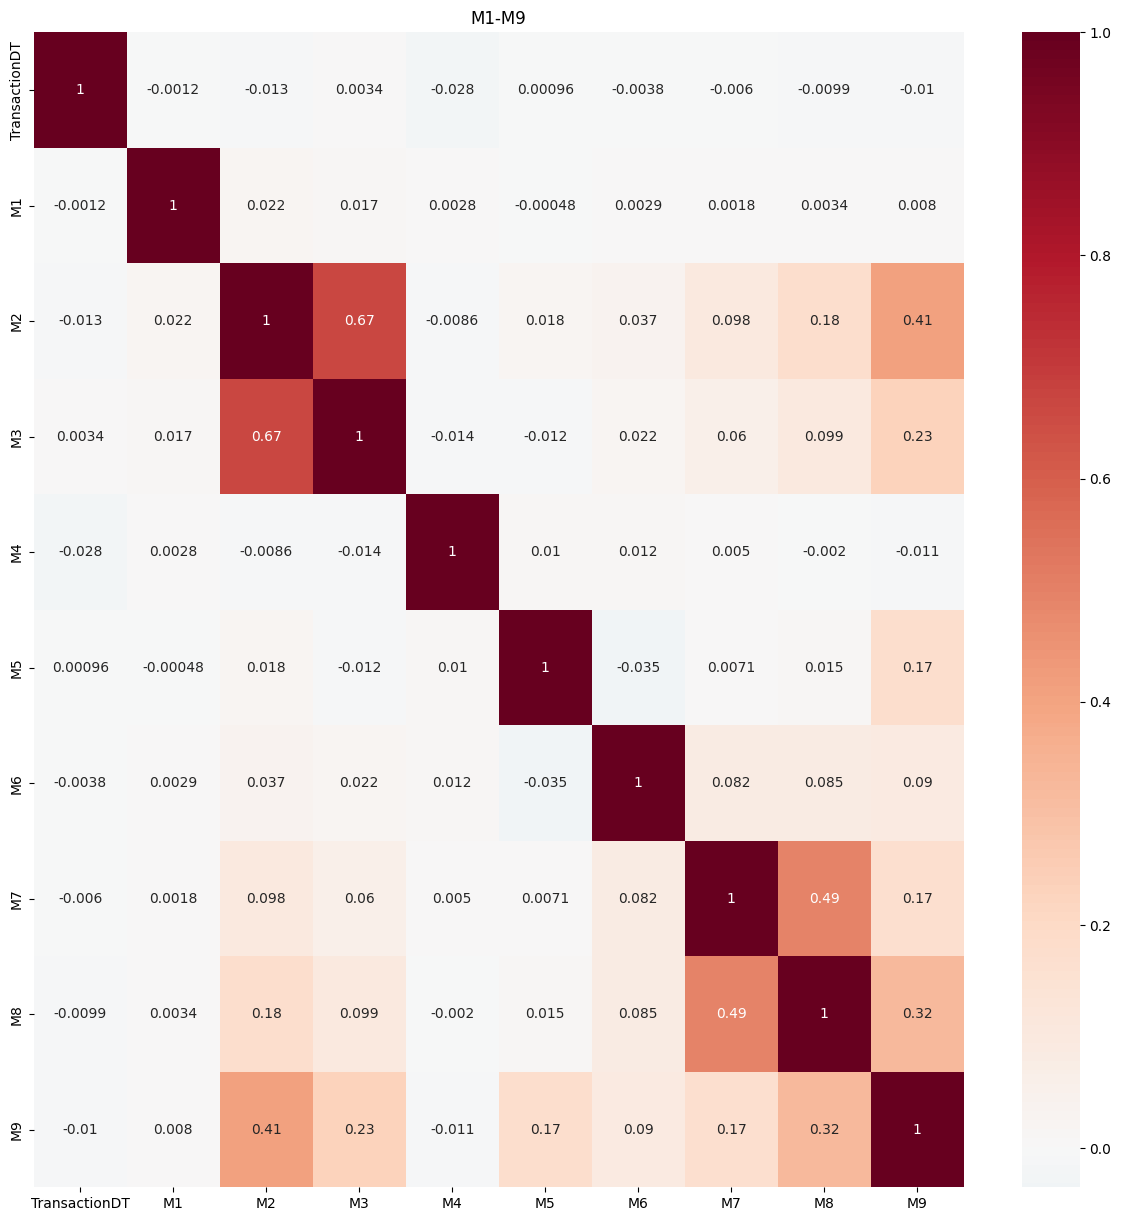

In [18]:
cols = ['TransactionDT'] + Ms
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('M1-M9')
plt.show()

In [19]:
train_id = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_identity.csv')
train_id = pd.merge(train_id,train[['TransactionID','TransactionDT']],on='TransactionID',how='left')
ids = ['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,39)]
for c in ids: print (c,train_id[c].unique()[:10])

id_01 [  0.  -5. -15. -10. -20. -40. -30. -25. -55. -45.]
id_02 [ 70787.  98945. 191631. 221832.   7460.  61141.     nan  31964. 116098.
 257037.]
id_03 [nan  0.  3.  2.  5.  1.  6.  9.  4. -5.]
id_04 [ nan   0. -11.  -5.  -8.  -1.  -6.  -9.  -3. -13.]
id_05 [nan  0.  1.  3.  2.  9. 12.  6.  4. 21.]
id_06 [ nan  -5.   0.  -6. -10. -11.  -1.  -4. -43.  -9.]
id_07 [nan 22.  6. -1.  4.  2. 17. 12. 27.  5.]
id_08 [  nan  -34.  -55. -100.  -15.  -33.  -13.  -36.  -44.  -26.]
id_09 [nan  0.  3.  2.  1.  5. -8.  7.  4.  6.]
id_10 [ nan   0.  -9. -42.  -6. -29.  -8.  -1.  -5. -11.]
id_11 [100.                  nan  93.75        95.08000183  95.65000153
  94.29000092  96.19000244  90.56999969  97.54000092  96.43000031]
id_12 ['NotFound' 'Found']
id_13 [nan 49. 52. 14. 20. 55. 43. 18. 41. 63.]
id_14 [-480. -300.   nan -360. -420. -540. -600.  480. -240.  300.]
id_15 ['New' 'Found' nan 'Unknown']
id_16 ['NotFound' 'Found' nan]
id_17 [166. 121. 225.  nan 102. 148. 199. 146. 144. 133.]
id_18 [nan 1

In [20]:
booln = ['id_12','id_15','id_16','id_27','id_28','id_29','id_35','id_36','id_37','id_38']
cats = ['id_23','id_30','id_31','id_33','id_34']
mp = {'Unknown':0,'NotFound':1,'Found':2,'New':3,'F':0,'T':1}
for c in booln: train_id[c] = train_id[c].map(mp)

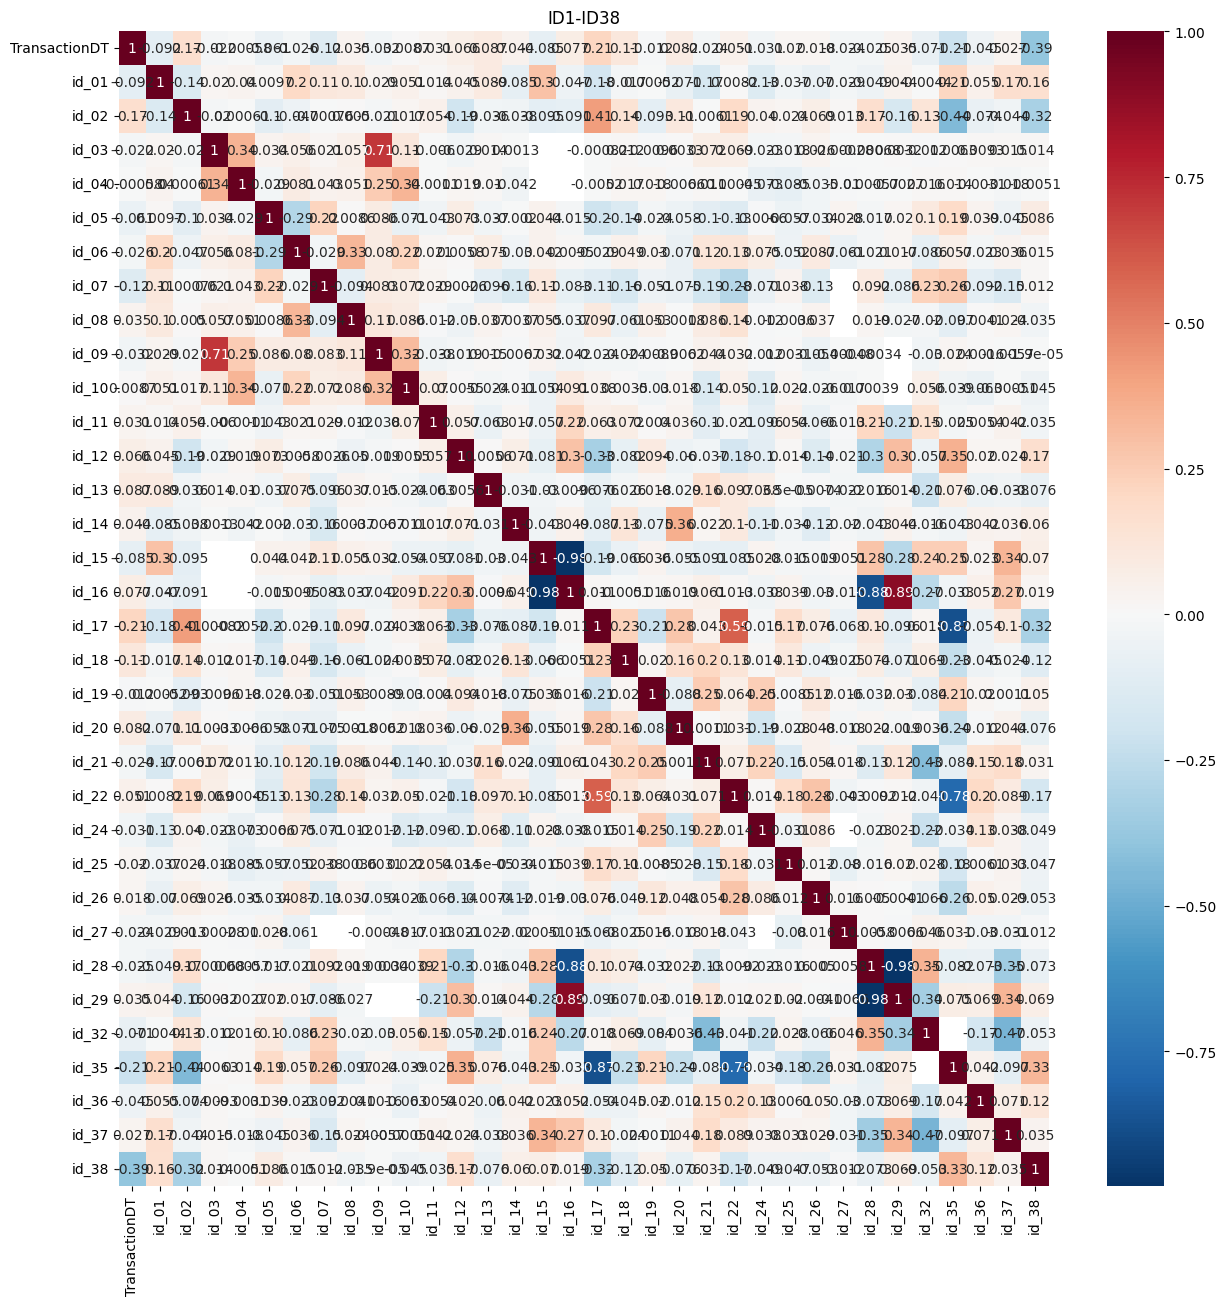

In [21]:
cols = ['TransactionDT'] + [x for x in ids if x not in cats]
plt.figure(figsize=(15,15))
sns.heatmap(train_id[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('ID1-ID38')
plt.show()

In [22]:
del train, train_id

In [23]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
cols += chosen_v_features

In [24]:
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: 
    dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [26]:
# LOAD TRAIN
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
#X_train = reduce_mem_usage(X_train)
# LOAD TEST
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/test_identity.csv',index_col='TransactionID', dtype=dtypes)
test_id.columns = train_id.columns
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
#X_test = reduce_mem_usage(X_test)

# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 234) test shape (506691, 234)


In [27]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue # Not time deltas
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

In [28]:
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

# Feature Engineering

**Encoded Functions**



In [29]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [30]:
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

In [31]:
X_train.shape, X_test.shape

((590540, 262), (506691, 262))

In [32]:
#Most of below columns are NAN
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

In [33]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [34]:
# UID features are created to help the M.L. model identify clients. 
# Client based classification leads to better predictions rather than transaction based clssification.
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [35]:
# New aggregations with UID

# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')


uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15


In [36]:
# 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14' are mostly NANs
# DT_M, day, UID will be removed to avoid overfitting as these created attributes are included in aggregations.

cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    if c in cols:
        cols.remove(c)
for c in ['DT_M','day','uid']:
    if c in cols:
        cols.remove(c)

In [37]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 301 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5',
       'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1',
       'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6', 'V8',
       'V11', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30',
       'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V52', 'V54',
       'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76',
       'V78', 'V80', 'V81', 'V82', 'V86', 'V88', 'V89', 'V91', 'V98',
       'V99', 'V104', 'V107', 'V108', 'V109', 'V111', 'V114', 'V115',
       'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129',
       'V130', 'V131', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156',
       'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V173', 'V174',
       'V175', '

In [38]:
### Local validation to decide whether to pass these attributes to the model.
### Parameters from : https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

import xgboost as xgb

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='gpu_hist' 
    )
h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
    eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.79605
[50]	validation_0-auc:0.88427
[100]	validation_0-auc:0.90560
[150]	validation_0-auc:0.92243
[200]	validation_0-auc:0.93454
[250]	validation_0-auc:0.94077
[300]	validation_0-auc:0.94477
[350]	validation_0-auc:0.94670
[400]	validation_0-auc:0.94763
[450]	validation_0-auc:0.94813
[500]	validation_0-auc:0.94814
[550]	validation_0-auc:0.94810
[600]	validation_0-auc:0.94811
[630]	validation_0-auc:0.94811


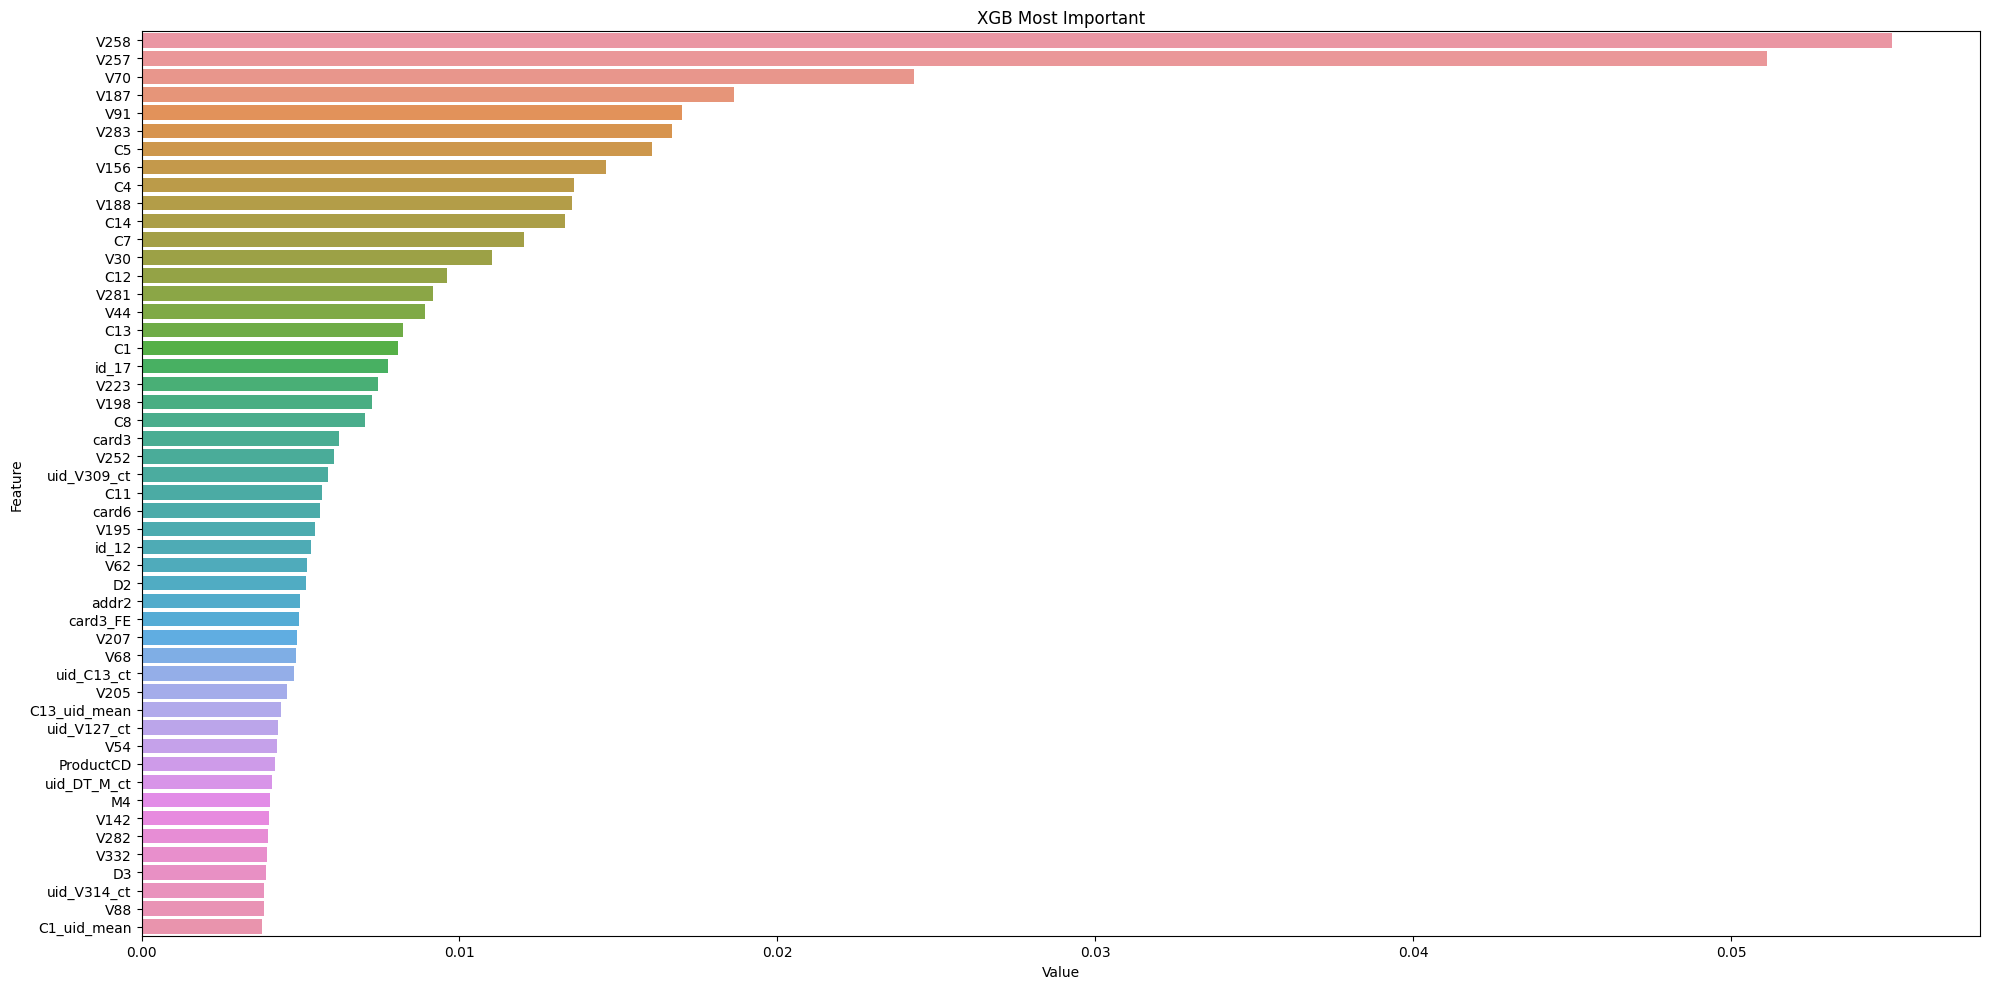

In [39]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB Most Important')
plt.tight_layout()
plt.show()
    
del clf, h; x=gc.collect()

#Hyper Parameter Tuning



In [40]:
# https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d

import time
from sklearn.model_selection import RandomizedSearchCV
clf = xgb.XGBClassifier()

param_grid = {
        'max_depth': [6, 12],
        'learning_rate': [0.002, 0.02, 0.2],
        'subsample': [0.4, 0.8],
        'colsample_bytree': [0.4],
        'n_estimators': [2000, 5000],
        'tree_method':['gpu_hist']}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=6, n_jobs=3, verbose=20, 
                            cv=3, scoring='roc_auc', refit=False, random_state=42)

In [41]:
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train[cols], y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: ignored

In [43]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

tr_pred = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.002,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist'
        # USE GPU
        tree_method='gpu_hist' 
    )        
    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=250, early_stopping_rounds=100)

    tr_pred[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
    del h, clf
    x=gc.collect()
print('#'*20)
print ('XGB CV=',roc_auc_score(y_train,tr_pred)) #Total Train dataset

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.77958
[250]	validation_0-auc:0.87225
[500]	validation_0-auc:0.88004
[750]	validation_0-auc:0.88709
[1000]	validation_0-auc:0.89454
[1250]	validation_0-auc:0.90073
[1500]	validation_0-auc:0.90570
[1750]	validation_0-auc:0.91003
[2000]	validation_0-auc:0.91372
[2250]	validation_0-auc:0.91579
[2500]	validation_0-auc:0.91763
[2750]	validation_0-auc:0.91934
[3000]	validation_0-auc:0.92023
[3250]	validation_0-auc:0.92084
[3500]	validation_0-auc:0.92143
[3750]	validation_0-auc:0.92177
[4000]	validation_0-auc:0.92217
[4250]	validation_0-auc:0.92266
[4500]	validation_0-auc:0.92310
[4750]	validation_0-auc:0.92355
[4999]	validation_0-auc:0.92395
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.81777
[250]	validation_0-auc:0.89803
[500]	validation_0-auc:0.90738
[750]	validation_0-auc:0.91601
[1000]	validation_0-auc:0.92420
[1250]	validation_0-auc:0.

In [44]:
preds

array([0.00048147, 0.0007351 , 0.00118418, ..., 0.00581457, 0.00757605,
       0.00584061])



----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------





---

